# Define MHWs using Hobday definition

In [1]:
import xarray as xr
import pandas as pd
import json
import gcsfs
import numpy as np
import cmocean
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from scipy import stats
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm
from xgcm import Grid
import xgcm 
from xgcm.autogenerate import generate_grid_ds
from xhistogram.xarray import histogram
import geopandas as gpd
import regionmask
import gsw
import glob

In [3]:
gpath = '/work5/stb/MHW-gfdl/Collab-LG_SS/cmems_mod_glo_phy_my_0.083deg_P1M-m_so-thetao_98.00W-80.00W_17.00N-31.00N_0.49-5727.92m_1993-01-01-2025-08-01.nc'
#esm4_path = '/work5/stb/ESM4/historical_1850-2014/ts/ocean_monthly_z.*.*.nc'
oisst_path = '/work5/stb/MHW-gfdl/Collab-LG_SS/OISST_gom_1981-2025_daily_sst.nc'
era_path = '/work/Shanice.Bailey/MHW-gfdl/compare_avgs_trends/ERA5/ds_era5.nc'

cora = xr.open_dataset('/work5/stb/MHW-gfdl/cora.nc', chunks={})
glorys_ds = xr.open_dataset(gpath, chunks={})
#ds_z = xr.open_mfdataset(esm4_path, chunks={}, decode_timedelta=True)
oisst_ds = xr.open_dataset(oisst_path)#, chunks={})
era = xr.open_dataset(era_path, chunks={})

|  | OISST | CORA | GLORYS | ERA5 |
| :---------- | :---------- | :----------: | ----------: | :---------- |
| Temperature | SST | 3D | 3D | SST |
| Sampling<br>frequency | Daily | Monthly | Monthly | Daily |
| Lat/Lon<br>resolution | 0.25˚ x 0.25˚ | 0.1˚ x 0.5˚ | 1/12˚ x 1/12˚ | 0.25˚ x 0.25˚ |
|Time period | 1981-09 : 2025-09 | 1980-01 : 2024-06 | 1993-01 : 2025-08 | 1983-01 : 2021-06 |

In [5]:
oisst_ds.lon

<xarray.DataArray 'lon' (lon: 84)> Size: 336B
array([260.125, 260.375, 260.625, 260.875, 261.125, 261.375, 261.625, 261.875,
       262.125, 262.375, 262.625, 262.875, 263.125, 263.375, 263.625, 263.875,
       264.125, 264.375, 264.625, 264.875, 265.125, 265.375, 265.625, 265.875,
       266.125, 266.375, 266.625, 266.875, 267.125, 267.375, 267.625, 267.875,
       268.125, 268.375, 268.625, 268.875, 269.125, 269.375, 269.625, 269.875,
       270.125, 270.375, 270.625, 270.875, 271.125, 271.375, 271.625, 271.875,
       272.125, 272.375, 272.625, 272.875, 273.125, 273.375, 273.625, 273.875,
       274.125, 274.375, 274.625, 274.875, 275.125, 275.375, 275.625, 275.875,
       276.125, 276.375, 276.625, 276.875, 277.125, 277.375, 277.625, 277.875,
       278.125, 278.375, 278.625, 278.875, 279.125, 279.375, 279.625, 279.875,
       280.125, 280.375, 280.625, 280.875], dtype=float32)
Coordinates:
  * lon      (lon) float32 336B 260.1 260.4 260.6 260.9 ... 280.4 280.6 280.9
Attributes:
    standard_name:  longitude
    long_name:      Longitude
    units:          degrees_east
    axis:           X
    actual_range:   [260.125 280.875]

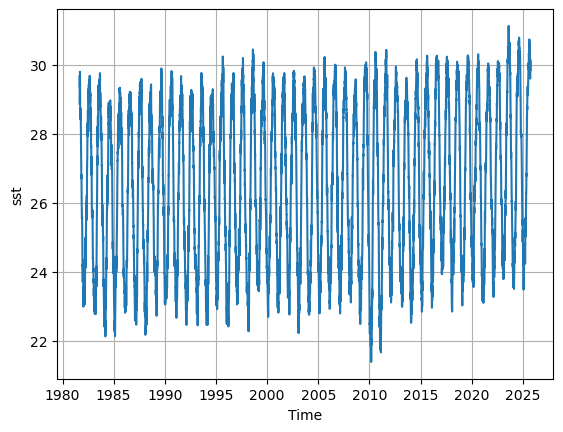

In [12]:
oisst_ds.sst.sel(lon=slice(None, 279.625)).mean(['lat', 'lon']).plot()
plt.grid()

In [ ]:
clim = oisst_ds.sst.sel(lon=slice(None, 279.625)).groupby('time.dayofyear').mean('time')

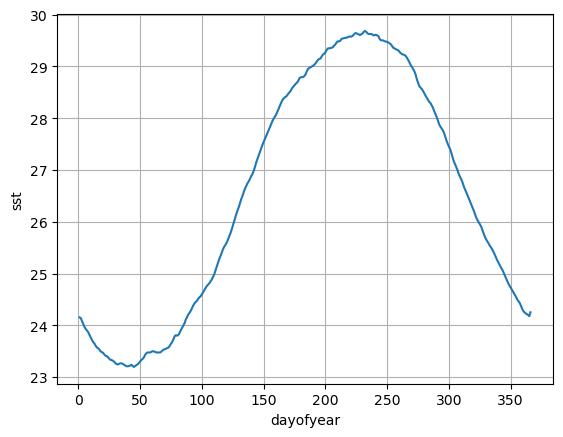

In [17]:
clim.mean(['lat','lon']).plot()
plt.grid()

In [68]:
#Group by day of the year and then calculate the 90th percentile
da = oisst_ds.sst.sel(lon=slice(None, 279.625)).groupby('time.dayofyear')
baseline_p90 = da.quantile(0.9, dim='time')

#reindex the baseline_p90 to match the full dataset's dayofyear
current_p90_threshold = baseline_p90.sel(dayofyear=oisst_ds.time.dt.dayofyear)

#Identify days where current temperature exceeds the 90th percentile baseline
exceedance_days = oisst_ds.sst.where(oisst_ds.sst > current_p90_threshold)
#Make boolean mask of days that exceed 90th percentile
exceedance_mask_bool = (oisst_ds.sst > current_p90_threshold)
#Make boolean mask int to count days for 5-day threshold
exceedance_int = exceedance_mask_bool.astype(int)
#Identify the events that are >=5 days
consecutive_exceedances = exceedance_int.rolling(time=5, center=False).sum()
long_exceedance_periods = consecutive_exceedances >= 5

# Count the number of days exceeding the 90th percentile in a specific year:
target_year_exceedances = exceedance_days.sel(time='2015').count()
print(f"Number of days exceeding the 90th percentile in 2015: {target_year_exceedances.item()}")

Number of days exceeding the 90th percentile in 2015: 241108


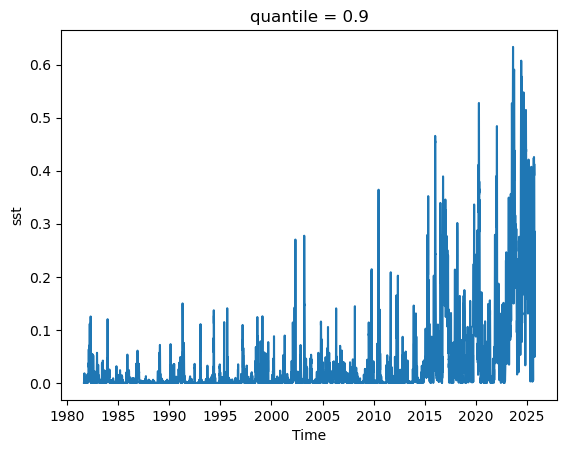

In [72]:
long_exceedance_periods.mean(['lat', 'lon']).plot()

In [69]:
#Sum up all the days that exceed 90th/5-day threshold in each year
yrs_list = np.unique(exceedance_days.time.dt.year)
exceedance_days_by_yr = []
for year in yrs_list:
    exceedance_days_by_yr.append(exceedance_days.sel(time=f'{year}').count())

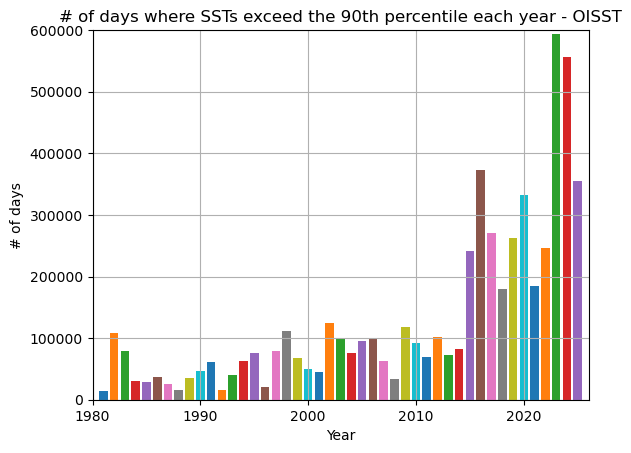

In [60]:
for (year, exc_days) in zip(yrs_list, exceedance_days_by_yr):
    plt.bar(year, exc_days)
plt.ylabel('# of days')
plt.xlabel('Year')
plt.ylim(0, 600000)
plt.xlim(1980, 2026)
plt.title('# of days where SSTs exceed the 90th percentile each year - OISST')
plt.grid();

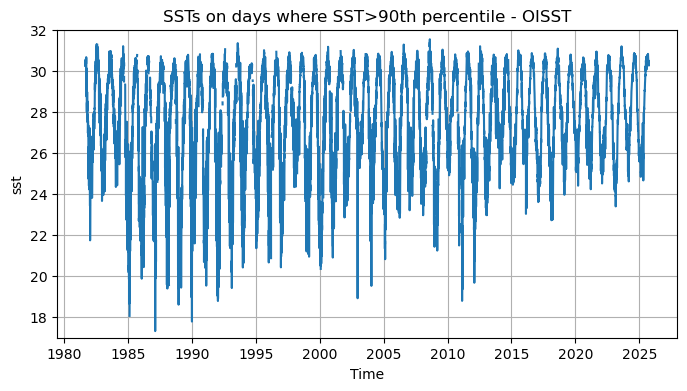

In [52]:
exceedance_days.mean(['lat', 'lon']).plot(figsize=(8,4))
plt.grid()
plt.ylim(17,32)
plt.title('SSTs on days where SST>90th percentile - OISST');